In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
from rubin_sim.maf import radar
import os

from matplotlib.legend_handler import HandlerErrorbar

In [2]:
def norm_df(
    df,
    runs,
    cols,
    norm_run="baseline",
    invert_cols=None,
    reverse_cols=None,
    run_label="run_name",
    mag_cols=[],
):
    """
    Normalize values in a dataframe to a given run
    Parameters
    ----------
    df : pandas.DataFrame
        The input data frame
    runs : list of str
        A list of run numes
    cols : list of str
        A list of columns in df to use
    norm_run : str
        The row to use to normalize things to
    invert_cols : list of str
        A list of column names that should be inverted (e.g., columns that
        are uncertainties and are better with a smaller value)
    reverse_cols : list of str
        Columns to reverse (e.g., magnitudes)
    run_label : str (run_name)
        The column that has run names
    mag_cols : list of str
        Columns that are in magnitudes
    """
    indices = [np.max(np.where(df.index == name)[0]) for name in runs]
    out_df = df[cols].iloc[indices].copy()
    if reverse_cols is not None:
        for colname in reverse_cols:
            out_df[colname] = -out_df[colname]
    if invert_cols is not None:
        for colname in invert_cols:
            out_df[colname] = 1.0 / out_df[colname]
    if norm_run is not None:
        indx = np.max(np.where(out_df.index == norm_run)[0])
        for col in out_df.columns:
            # maybe just check that it's not a
            if col != "run_name":
                if (col in mag_cols) | (mag_cols == "all"):
                    out_df[col] = 1.0 + (out_df[col] - out_df[col].iloc[indx])
                else:
                    out_df[col] = (
                        1.0
                        + (out_df[col] - out_df[col].iloc[indx])
                        / out_df[col].iloc[indx]
                    )
    return out_df

In [3]:

data_loaded = pd.read_hdf('summary.h5')
data_loaded.shape

(38, 51305)

In [4]:
data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['ender_a1_v3.1_10yrs'], data_loaded['Sum PrestoKNe_score_s UserPointsSlicer'].loc['baseline_v3.0_10yrs']

(204.0, 200.0)

In [28]:
#[col for col in data_loaded.columns if 'LVDwarfs' in col]
#[col for col in data_loaded.columns if 'KNePop' in col and 'Total detected' in col and 'ztfrest_simple ' in col and 'DD' in col ]
[col for col in data_loaded.columns if 'DD' in col and 'NVisits' in col and 'all bands' in col]

['Median DD:COSMOS NVisits all bands HealpixSubsetSlicer',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer']

In [29]:
# Pull out the metrics we are interested in and define simple names

name_dict = {'FootprintFraction N year 1 u and night < 365 HealpixSlicer': 'FF u',
            'FootprintFraction N year 1 g and night < 365 HealpixSlicer': 'FF g',
            'FootprintFraction N year 1 r and night < 365 HealpixSlicer': 'FF r',

            'FootprintFraction N year 1 i and night < 365 HealpixSlicer': 'FF i',
    'best18k parallax HealpixSlicer': 'parallax best 18k',
            'best18k properMotion HealpixSlicer': 'proper motion best 18k',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 20_30 days UserPointsSlicer': '20-30d microlensing\ndetection',
            'Fraction detected of total (mean) MicrolensingMetric_detect tE 60_90 days UserPointsSlicer': '60-90d microlensing\ndetection',
            'fONv MedianNvis fO HealpixSlicer': 'fO N vis',
            'Total detected SNNSNMetric_reducen_sn DDF excluded HealpixSlicer': 'SNe, N',
             'Median SNNSNMetric_reducezlim DDF excluded HealpixSlicer': 'SNe, zlim',
            '3x2ptFoM Exgalm5WithCuts i band non-DD year 10 HealpixSlicer': '3x2 i-band',
            'Median WeakLensingNvisits gri band non-DD HealpixSlicer': 'WL Nvis \ni-band',
            'Total detected KNePopMetric_all_ztfrest_simple all models UserPointsSlicer': 'KNe ZTF simple',
             'Total detected KNePopMetric_single_ztfrest_simple single model UserPointsSlicer': 'KNe single model',
             'Sum PrestoKNe_score_p UserPointsSlicer': 'KNe Score, P',
            'Total detected XRBPopMetric_early_detect UserPointsSlicer': 'XRB\nearly detect',
            'VolumeSum Brown Dwarf, L7 HealpixSlicer': 'Brown Dwarf Vol',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO bright',
            'CumulativeCompleteness H <= 22.000000 DiscoveryNChances NEO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'NEO faint',
            'CumulativeCompleteness H <= 6.000000 DiscoveryNChances TNO 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'TNO',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances MBA 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'MBA',
            'CumulativeCompleteness H <= 18.000000 DiscoveryNChances Trojan 3 pairs in 15 nights SNR=3 detection loss MoObjSlicer': 'Trojan',
            'CumulativeCompleteness H <= 16.000000 DiscoveryNChances Vatira 1 quad in 1 night detection loss MoObjSlicer': 'Vatira',
            'CumulativeCompleteness H <= 20.000000 DiscoveryNChances PHA 1 quad in 1 night detection loss MoObjSlicer': 'PHA, quad'}
            #}
# drop in the units for the columns
units = {'parallax best 18k': 'mas',
         'proper motion best 18k': 'mas/yr',
         '20-30d microlensing\ndetection': 'fraction', 
         '60-90d microlensing\ndetection': 'fraction', 
         'fO N vis' : '', 
         'SNe, N': '', 
         'SNe, zlim': '', 
         '3x2 i-band': 'score', 
         'WL Nvis \ni-band': '', 
         'KNe ZTF simple': 'N', 
         'KNe single model': 'N',
         'KNe Score, P': 'score',
         'XRB\nearly detect': 'N', 
         'Brown Dwarf Vol': 'pc^3', 
         'NEO bright': 'fraction', 
         'NEO faint': 'fraction', 
         'TNO': 'fraction', 
         'MBA':'fraction',
         'Trojan': 'fraction',
         'Vatira': 'fraction',
         'PHA, quad': 'fraction',
         'FF u': '',
         'FF g': '',
         'FF r': '',
         'FF i': '',
        }

# If columns are uncertainties, we want to plot them backwards
invert_cols = ['parallax best 18k', 'proper motion best 18k']
# If columns are mags or fractions, we want to plot differences, not fractional differences.
mag_cols = ['20-30d microlensing\ndetection', '60-90d microlensing\ndetection','SNe, zlim',
            'NEO bright', 'NEO faint', 'TNO', 'Vatira', 'MBA', 'Trojan']

data = pd.DataFrame()
for key in name_dict:
    data[name_dict[key]] = data_loaded[key]
    

mag_dict = {'Median CoaddM5 g HealpixSlicer': 'g',
 'Median CoaddM5 i HealpixSlicer': 'i',
 'Median CoaddM5 r HealpixSlicer': 'r',
 'Median CoaddM5 u HealpixSlicer': 'u',
 'Median CoaddM5 y HealpixSlicer': 'y',
 'Median CoaddM5 z HealpixSlicer': 'z'}

mag_data = pd.DataFrame()
for key in mag_dict:
    mag_data[mag_dict[key]] = data_loaded[key]
    
    
    
ddf_dict = {'Sum SNNSNMetric DD:COSMOS_reducen_sn DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN COSMOS',
           'Sum SNNSNMetric DD:ECDFS_reducen_sn DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ECDFS',
           'Sum SNNSNMetric DD:EDFS_reducen_sn DD:EDFS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN EDFS',
           'Sum SNNSNMetric DD:ELAISS1_reducen_sn DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer' : 'N SN ELAISS1',
           'Sum SNNSNMetric DD:XMM_LSS_reducen_sn DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer' : 'N SN XMM_LSS',
            
           'Median SNNSNMetric DD:COSMOS_reducezlim DD:COSMOS all bands, only DDF observations HealpixSubsetSlicer': 'zlim COSMOS',
            'Median SNNSNMetric DD:ECDFS_reducezlim DD:ECDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim ECDFS',
            'Median SNNSNMetric DD:EDFS_reducezlim DD:EDFS all bands, only DDF observations HealpixSubsetSlicer': 'zlim EDFS',
            'Median SNNSNMetric DD:ELAISS1_reducezlim DD:ELAISS1 all bands, only DDF observations HealpixSubsetSlicer': 'zlim ELAISS1',
            'Median SNNSNMetric DD:XMM_LSS_reducezlim DD:XMM_LSS all bands, only DDF observations HealpixSubsetSlicer': 'zlim XMM_LSS',
            
           'Total detected KNePopMetric_DD:COSMOS_ztfrest_simple DD:COSMOS UserPointsSlicer': 'Kne COSMOS',
         'Total detected KNePopMetric_DD:ECDFS_ztfrest_simple DD:ECDFS UserPointsSlicer': 'Kne ECDFS',
 'Total detected KNePopMetric_DD:EDFS_ztfrest_simple DD:EDFS UserPointsSlicer': 'Kne EDFS',
 'Total detected KNePopMetric_DD:ELAISS1_ztfrest_simple DD:ELAISS1 UserPointsSlicer': 'Kne ELAISS1',
 'Total detected KNePopMetric_DD:WFD_ztfrest_simple DD:WFD UserPointsSlicer': 'Kne WFD',
 'Total detected KNePopMetric_DD:XMM_LSS_ztfrest_simple DD:XMM_LSS UserPointsSlicer': 'Kne XMM_LSS',
            
            'Median DD:COSMOS NVisits all bands HealpixSubsetSlicer':'N COSMOS',
 'Median DD:ECDFS NVisits all bands HealpixSubsetSlicer': 'N ECDFS',
 'Median DD:EDFS NVisits all bands HealpixSubsetSlicer': 'N EDFS',
 'Median DD:ELAISS1 NVisits all bands HealpixSubsetSlicer': 'N ELAISS1',
 'Median DD:WFD NVisits all bands HealpixSubsetSlicer': 'N WFD',
 'Median DD:XMM_LSS NVisits all bands HealpixSubsetSlicer': 'N XMM_LSS', 
           }

ddf_data = pd.DataFrame()
for key in ddf_dict:
    ddf_data[ddf_dict[key]] = data_loaded[key]
 
gaps_dict = {}
for filtername in 'ugrizy':
    for times in [3,7,24]:
        gaps_dict['Mean Gaps_%ihr %s band HealpixSlicer' % (times, filtername)] = 'gaps %s %i' % (filtername, times)
        
gaps_data = pd.DataFrame()
for key in gaps_dict:
    gaps_data[gaps_dict[key]] = data_loaded[key]

In [30]:
#data['KNe single model'] # data['KNe ZTF simple']

In [31]:
# A bit of a mystery why baseline_v3.0_10yrs is so much better. 
# The KNe ZTF simple and KNe single model don't seem to
# be particularly well correlated. Seems like it has to be an MJD_start bug somewhere, but I can't find it.
#data['KNe ZTF simple']

In [32]:
mag_data

,g,i,r,u,y,z
baseline_v2.0_10yrs,26.733479,26.218659,26.755971,25.818916,24.762720,25.510379
baseline_v2.1_10yrs,26.736248,26.252054,26.781543,25.751969,24.728145,25.486640
baseline_v2.2_10yrs,26.753646,26.290929,26.835430,25.724699,24.782743,25.581317
baseline_v3.0_10yrs,26.688123,26.264600,26.818287,25.668262,24.756955,25.524781
baseline_v3.2_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586
ender_a1_v3.1_10yrs,26.696522,26.280475,26.811614,25.622221,24.780784,25.566586
filter_u_y_short_v3.1_10yrs,26.695355,26.307837,26.816100,25.631341,24.779209,25.595641
filter_u_y_v3.1_10yrs,26.688689,26.295205,26.809752,25.619284,24.765767,25.584335
filter_u_z_short_v3.1_10yrs,26.710117,26.297013,26.842553,25.647528,24.799451,25.573902
filter_u_z_v3.1_10yrs,26.692658,26.282547,26.826725,25.635601,24.776856,25.561564


In [33]:
ddf_data
#ddf_data = ddf_data.reindex(new_ind)

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,...,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS,N COSMOS,N ECDFS,N EDFS,N ELAISS1,N WFD,N XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289,...,470.0,427.0,337.0,415.0,8937.5,9264.0,5497.0,9262.0,833.0,9024.0
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932,...,444.0,392.0,302.0,404.0,8900.0,9166.5,5506.0,9127.0,820.0,8941.0
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN,...,530.0,418.0,339.0,403.0,9853.0,9663.0,6150.0,9991.0,829.0,9869.0
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335,...,539.0,433.0,365.0,363.0,18716.5,10606.5,6668.0,10671.0,817.0,10845.0
baseline_v3.2_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,...,426.0,357.0,293.0,321.0,20610.5,11398.5,7135.0,10819.0,854.0,11121.0
ender_a1_v3.1_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,...,426.0,357.0,293.0,321.0,20610.5,11398.5,7135.0,10819.0,854.0,11121.0
filter_u_y_short_v3.1_10yrs,301.191635,NaN,NaN,NaN,NaN,0.597700,NaN,NaN,NaN,NaN,...,427.0,360.0,321.0,296.0,13186.5,7321.5,4886.0,7449.0,875.0,7755.0
filter_u_y_v3.1_10yrs,452.542667,80.017748,214.477253,75.567790,109.057917,0.588334,0.586219,0.521403,0.588983,0.554800,...,457.0,347.0,295.0,342.0,19501.0,10815.0,6790.0,10304.0,859.0,10708.0
filter_u_z_short_v3.1_10yrs,297.407602,NaN,NaN,NaN,NaN,0.597142,NaN,NaN,NaN,NaN,...,449.0,372.0,341.0,377.0,12788.0,7112.5,4791.0,7206.0,884.0,7530.0
filter_u_z_v3.1_10yrs,445.725384,69.724318,213.532164,79.823685,94.410211,0.581173,0.587997,0.506020,0.577380,0.543449,...,486.0,329.0,312.0,346.0,18974.5,10527.0,6672.0,10127.0,852.0,10455.0


In [11]:
gaps_data

,gaps u 3,gaps u 7,gaps u 24,gaps g 3,gaps g 7,gaps g 24,gaps r 3,gaps r 7,gaps r 24,gaps i 3,gaps i 7,gaps i 24,gaps z 3,gaps z 7,gaps z 24,gaps y 3,gaps y 7,gaps y 24
baseline_v2.0_10yrs,0.395707,0.068583,1.979227,0.320644,0.038605,2.905351,1.670229,0.288810,11.954574,1.331558,0.269865,10.719868,1.831030,0.297439,12.604586,1.536428,0.153594,8.004301
baseline_v2.1_10yrs,0.433578,0.070021,2.221766,0.398773,0.051526,2.924357,1.793484,0.249485,12.712741,1.420438,0.234489,11.354273,1.979644,0.310785,12.810815,1.780179,0.148189,7.699467
baseline_v2.2_10yrs,0.457299,0.135002,2.768322,0.256753,0.033120,3.146254,1.175353,0.201547,13.775634,0.918093,0.177043,11.986622,1.434292,0.261967,14.550917,0.989948,0.134256,6.432118
baseline_v3.0_10yrs,0.185499,0.185667,3.009013,0.137336,0.233687,2.604800,0.684745,1.140037,14.906642,0.828866,1.264784,12.805887,1.007000,0.876754,15.635885,0.520701,0.151562,7.131831
baseline_v3.2_10yrs,0.081171,0.059398,2.130439,0.422236,0.413635,2.590710,0.810905,0.537287,14.559337,1.226057,0.853937,13.040251,0.806594,0.418198,11.925169,0.671715,0.279243,8.586768
ender_a1_v3.1_10yrs,0.081171,0.059398,2.130439,0.422236,0.413635,2.590710,0.810905,0.537287,14.559337,1.226057,0.853937,13.040251,0.806594,0.418198,11.925169,0.671715,0.279243,8.586768
filter_u_y_short_v3.1_10yrs,0.127066,0.048134,2.373389,0.329579,0.344916,2.811635,0.867244,0.554244,15.270622,1.218541,0.808467,14.303478,0.754738,0.482840,11.764783,1.030959,0.371636,10.602588
filter_u_y_v3.1_10yrs,0.086144,0.048307,2.215983,0.354032,0.309400,2.700635,0.804791,0.552439,14.716193,1.285223,0.842376,13.585325,0.763077,0.396746,11.306636,0.990607,0.352308,10.275830
filter_u_z_short_v3.1_10yrs,0.113981,0.063439,2.330931,0.488300,0.483656,2.855919,0.856058,0.632674,17.455706,1.406970,0.858535,14.779897,0.952468,0.562429,18.557523,0.571343,0.211522,8.296030
filter_u_z_v3.1_10yrs,0.078989,0.053579,2.334096,0.485006,0.433147,2.909134,0.856383,0.574677,16.829578,1.261911,0.850016,14.326493,0.987526,0.564643,17.655369,0.626604,0.190709,7.963803


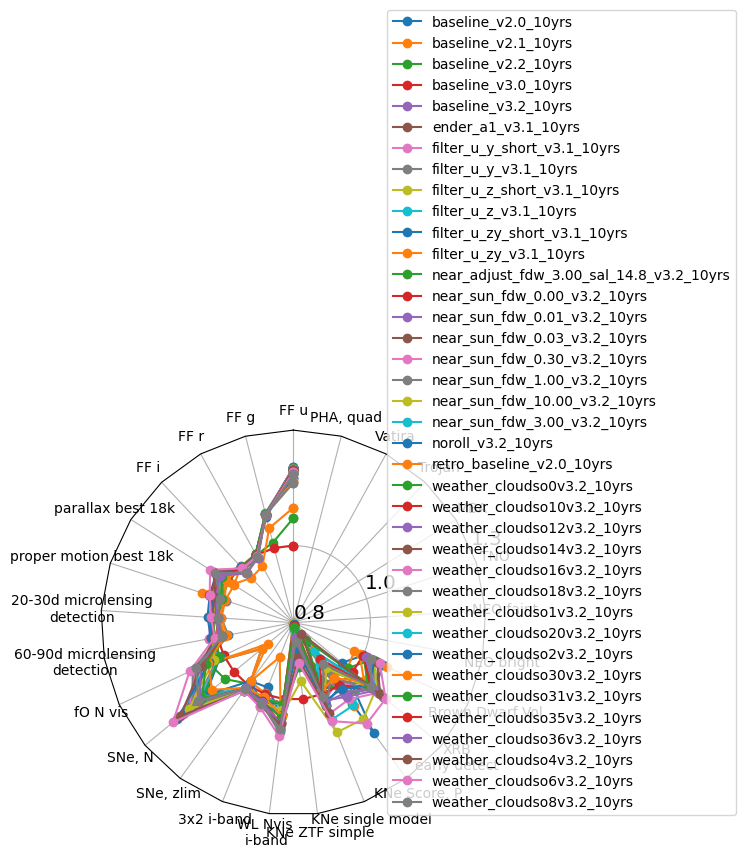

In [12]:
runs = [run for run in data.index ]
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.0_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.8, 1.0, 1.3], bbox_to_anchor=(1.65, 0))

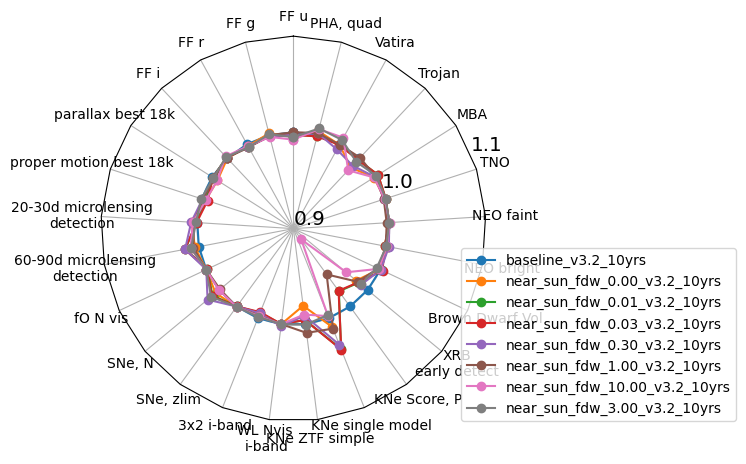

In [13]:
# near sun
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'near_sun' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

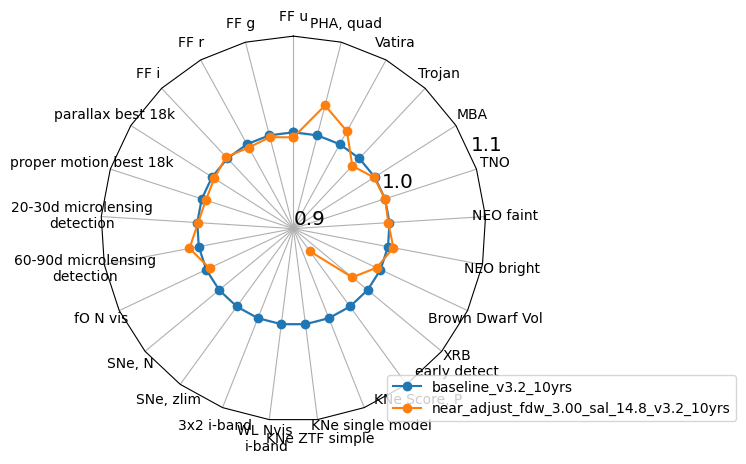

In [14]:
# near sun
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'near_a' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

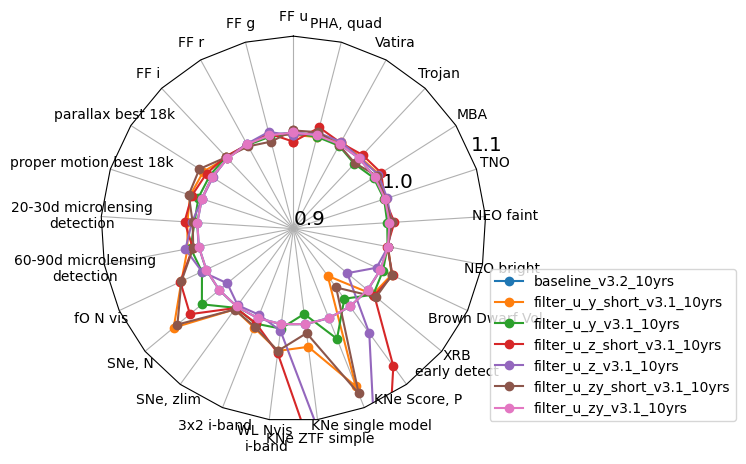

In [21]:
runs = ['baseline_v3.2_10yrs'] + [run for run in data.index if 'filter_u' in run] 
ndata = norm_df(data, runs, cols=data.columns.values.tolist(),
                invert_cols=invert_cols, mag_cols = mag_cols, norm_run='baseline_v3.2_10yrs')
fig, ax = radar(ndata, legend=True, rgrids=[0.9, 1.0, 1.1], bbox_to_anchor=(1.65, 0))

In [25]:
data.loc[runs]

,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
baseline_v3.2_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906
filter_u_y_short_v3.1_10yrs,0.975028,0.982211,0.996294,0.996788,0.773830,0.183110,0.3445,0.4754,828.0,128434.341988,...,226.072456,2095.0,175634.518589,0.9394,0.642457,0.721695,0.930945,0.599964,0.4477,0.868331
filter_u_y_v3.1_10yrs,0.976562,0.980235,0.996170,0.998147,0.779844,0.184722,0.3370,0.4721,809.0,123834.701059,...,232.980919,2096.0,173930.909299,0.9388,0.639774,0.720008,0.924147,0.590819,0.4428,0.868568
filter_u_z_short_v3.1_10yrs,0.968052,0.983817,0.996541,0.998394,0.776740,0.183418,0.3474,0.4698,829.0,125783.337845,...,253.359277,2099.0,175859.548434,0.9384,0.647211,0.720653,0.933554,0.603400,0.4463,0.877294
filter_u_z_v3.1_10yrs,0.974609,0.985300,0.997529,0.996170,0.782747,0.185466,0.3397,0.4776,809.0,119696.080162,...,243.348206,2023.0,172644.548557,0.9394,0.644416,0.723349,0.930032,0.599102,0.4472,0.872526
filter_u_zy_short_v3.1_10yrs,0.979492,0.975170,0.994565,0.997529,0.770048,0.182822,0.3390,0.4693,828.0,127827.035914,...,229.580267,2104.0,175721.179668,0.9392,0.644874,0.720809,0.928046,0.591761,0.4434,0.872895
filter_u_zy_v3.1_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906


In [15]:
data['Vatira']

baseline_v2.0_10yrs                            NaN
baseline_v2.1_10yrs                            NaN
baseline_v2.2_10yrs                            NaN
baseline_v3.0_10yrs                            NaN
baseline_v3.2_10yrs                         0.4445
ender_a1_v3.1_10yrs                         0.4445
filter_u_y_short_v3.1_10yrs                 0.4477
filter_u_y_v3.1_10yrs                       0.4428
filter_u_z_short_v3.1_10yrs                 0.4463
filter_u_z_v3.1_10yrs                       0.4472
filter_u_zy_short_v3.1_10yrs                0.4434
filter_u_zy_v3.1_10yrs                      0.4445
near_adjust_fdw_3.00_sal_14.8_v3.2_10yrs    0.4600
near_sun_fdw_0.00_v3.2_10yrs                0.4439
near_sun_fdw_0.01_v3.2_10yrs                0.4441
near_sun_fdw_0.03_v3.2_10yrs                0.4438
near_sun_fdw_0.30_v3.2_10yrs                0.4384
near_sun_fdw_1.00_v3.2_10yrs                0.4440
near_sun_fdw_10.00_v3.2_10yrs               0.4523
near_sun_fdw_3.00_v3.2_10yrs   

In [26]:
ddf_data

,N SN COSMOS,N SN ECDFS,N SN EDFS,N SN ELAISS1,N SN XMM_LSS,zlim COSMOS,zlim ECDFS,zlim EDFS,zlim ELAISS1,zlim XMM_LSS,Kne COSMOS,Kne ECDFS,Kne EDFS,Kne ELAISS1,Kne WFD,Kne XMM_LSS
baseline_v2.0_10yrs,47.333916,5.217382,NaN,81.438800,72.445437,0.596891,0.543027,NaN,0.593426,0.562289,398.0,401.0,470.0,427.0,337.0,415.0
baseline_v2.1_10yrs,21.899369,2.592571,NaN,40.212476,32.838014,0.594427,0.545216,NaN,0.594464,0.561932,382.0,413.0,444.0,392.0,302.0,404.0
baseline_v2.2_10yrs,13.647867,6.881372,NaN,3.753806,NaN,0.514987,0.577431,NaN,0.600156,NaN,398.0,435.0,530.0,418.0,339.0,403.0
baseline_v3.0_10yrs,362.726856,72.383449,74.734786,37.378088,60.363667,0.594675,0.575080,0.526724,0.546128,0.539335,476.0,442.0,539.0,433.0,365.0,363.0
baseline_v3.2_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0
ender_a1_v3.1_10yrs,567.853209,331.480163,698.794240,297.421154,311.588766,0.566437,0.588491,0.527025,0.577627,0.557767,368.0,361.0,426.0,357.0,293.0,321.0
filter_u_y_short_v3.1_10yrs,301.191635,NaN,NaN,NaN,NaN,0.597700,NaN,NaN,NaN,NaN,381.0,347.0,427.0,360.0,321.0,296.0
filter_u_y_v3.1_10yrs,452.542667,80.017748,214.477253,75.567790,109.057917,0.588334,0.586219,0.521403,0.588983,0.554800,368.0,375.0,457.0,347.0,295.0,342.0
filter_u_z_short_v3.1_10yrs,297.407602,NaN,NaN,NaN,NaN,0.597142,NaN,NaN,NaN,NaN,386.0,388.0,449.0,372.0,341.0,377.0
filter_u_z_v3.1_10yrs,445.725384,69.724318,213.532164,79.823685,94.410211,0.581173,0.587997,0.506020,0.577380,0.543449,383.0,386.0,486.0,329.0,312.0,346.0


In [16]:
times = ['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs',
        'baseline_v3.0_10yrs',  'baseline_v3.2_10yrs']

sub_data = data.reindex(labels=times)
sub_ddf = ddf_data.reindex(labels=times)
sub_mag = mag_data.reindex(labels=times)
sub_gaps = gaps_data.reindex(labels=times)
sub_data



,FF u,FF g,FF r,FF i,parallax best 18k,proper motion best 18k,20-30d microlensing\ndetection,60-90d microlensing\ndetection,fO N vis,"SNe, N",...,"KNe Score, P",XRB\nearly detect,Brown Dwarf Vol,NEO bright,NEO faint,TNO,MBA,Trojan,Vatira,"PHA, quad"
retro_baseline_v2.0_10yrs,0.893276,0.949104,0.960964,0.958616,0.804328,0.176701,0.0883,0.1533,848.0,97124.012102,...,202.730488,720.0,179640.718155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v2.0_10yrs,0.955776,0.981594,0.994441,0.997035,0.791058,0.184088,0.3116,0.4284,839.0,99302.532220,...,263.696398,1879.0,168086.074111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v2.1_10yrs,0.948661,0.984188,0.996912,0.999012,0.806910,0.188258,0.3111,0.4312,838.0,99294.339899,...,243.713720,1918.0,163815.013503,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v2.2_10yrs,0.871233,0.914268,0.993947,0.998023,0.792958,0.186345,0.3212,0.4462,830.0,112802.099640,...,242.377184,1920.0,172453.127988,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v3.0_10yrs,0.813058,0.901174,0.993823,0.999135,0.792666,0.185683,0.3239,0.4559,795.0,109475.798536,...,228.428876,1950.0,168032.537231,NaN,NaN,NaN,NaN,NaN,NaN,NaN
baseline_v3.2_10yrs,0.977539,0.981717,0.997035,0.995676,0.782077,0.185427,0.3341,0.4634,805.0,121007.562022,...,235.320866,2080.0,173433.444317,0.9392,0.642068,0.720883,0.925484,0.598403,0.4445,0.869906


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_16587/3763499284.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',


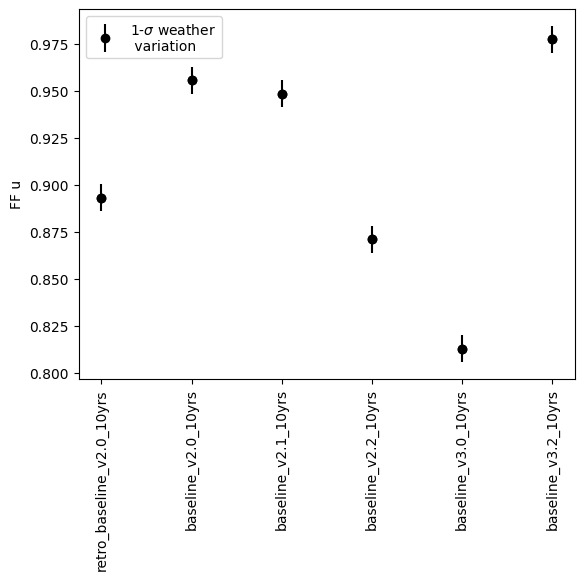

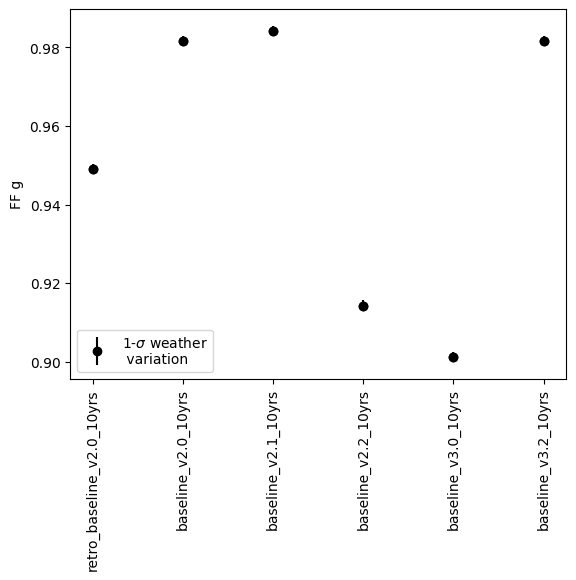

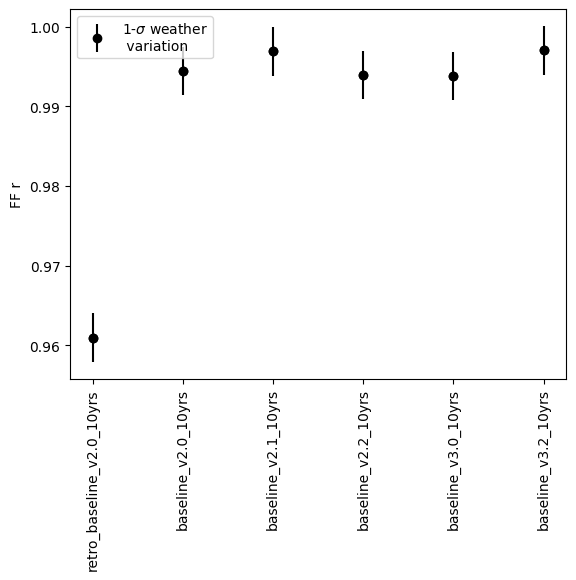

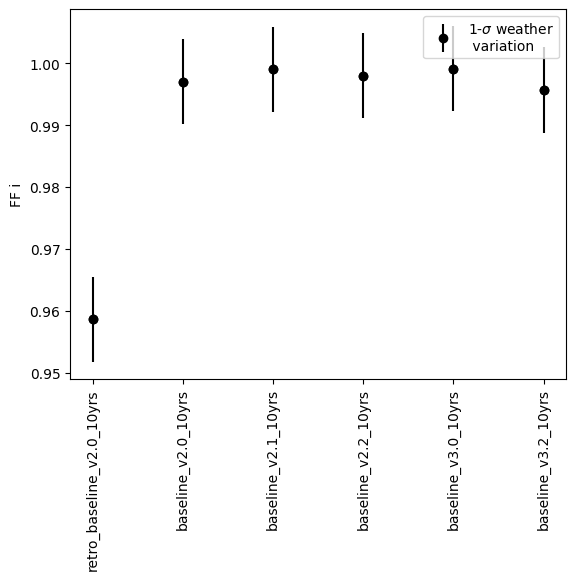

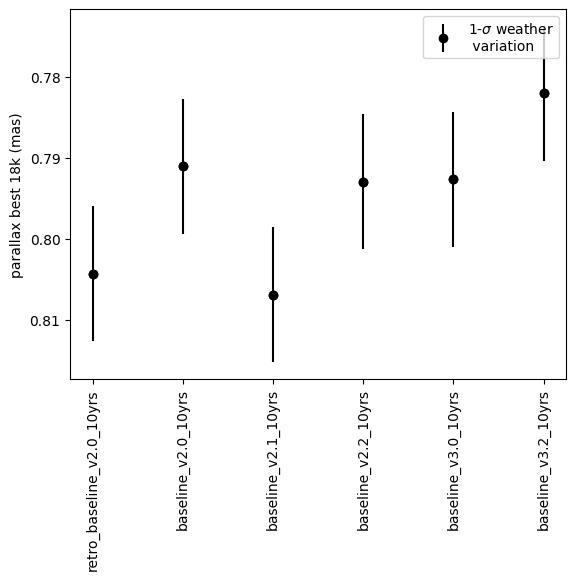

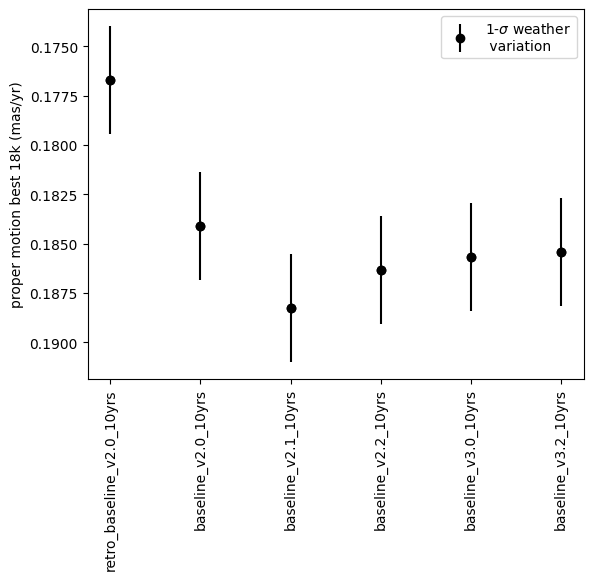

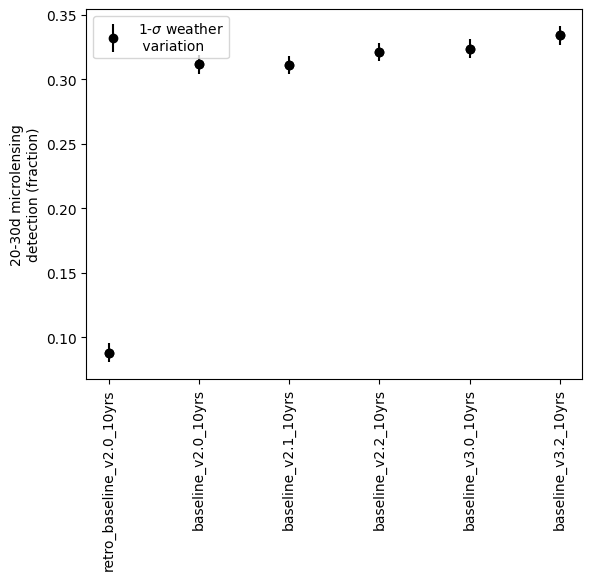

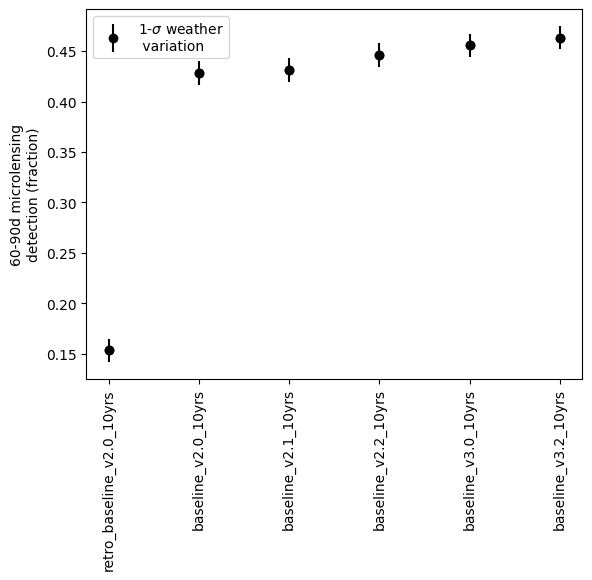

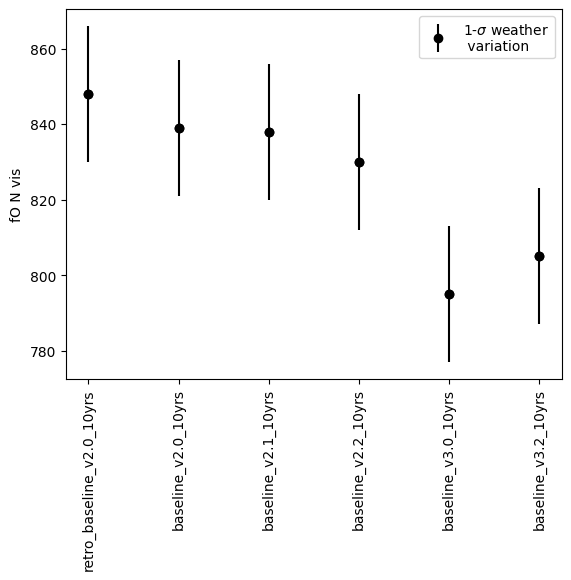

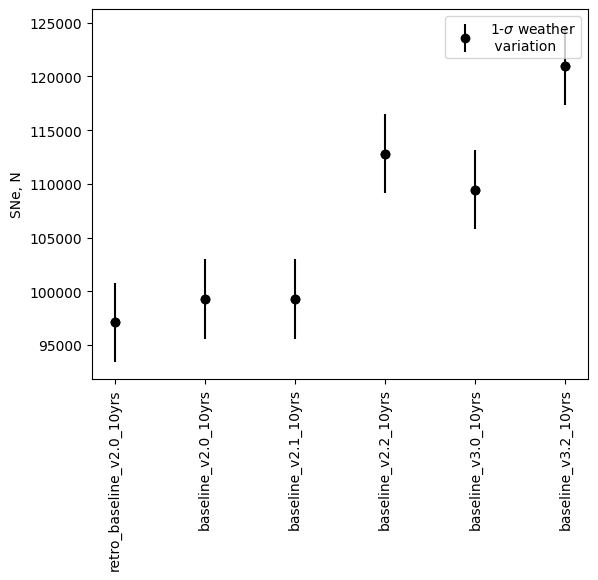

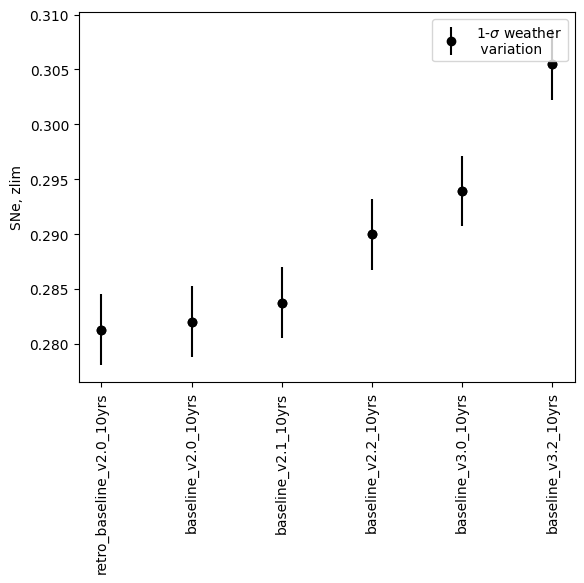

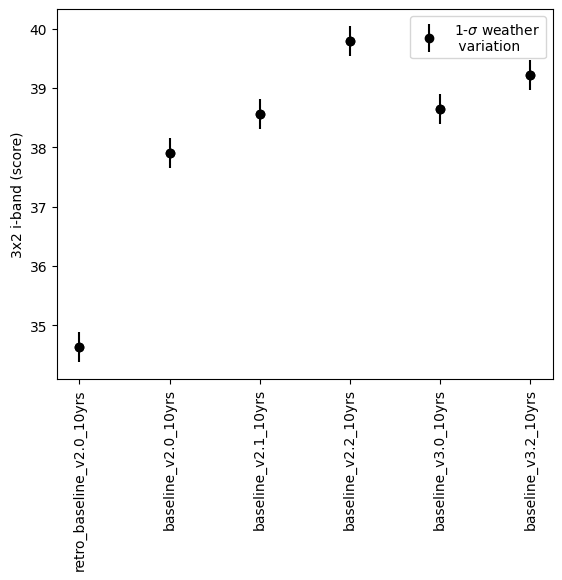

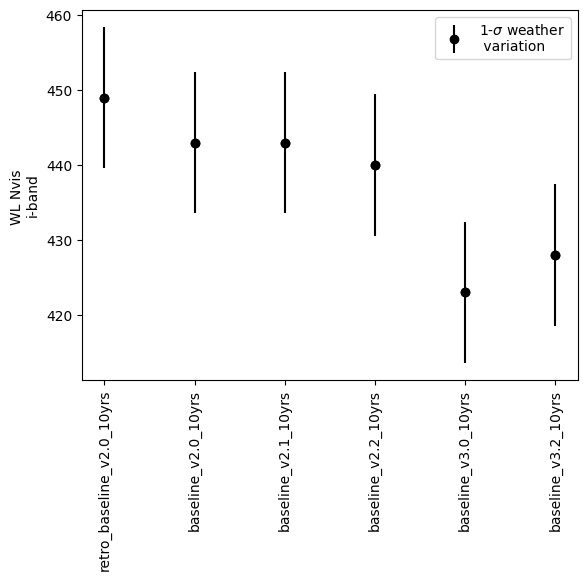

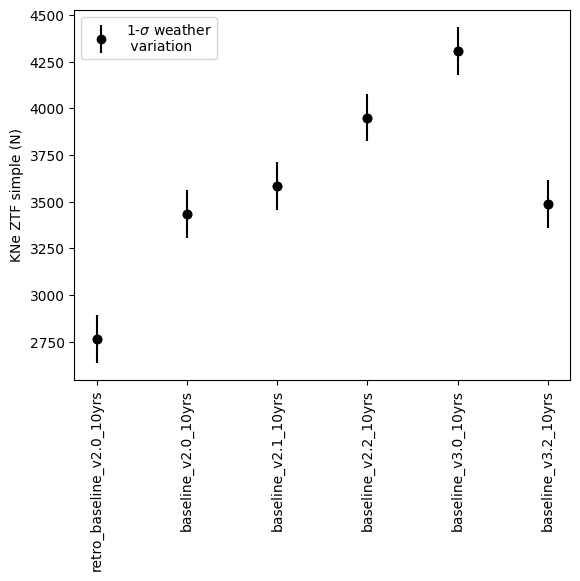

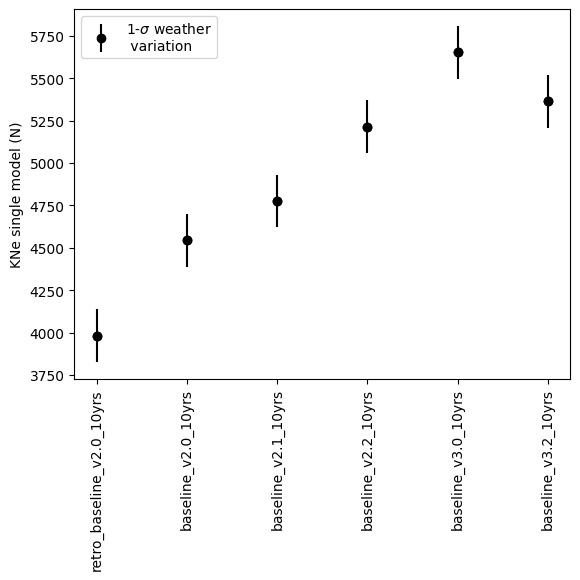

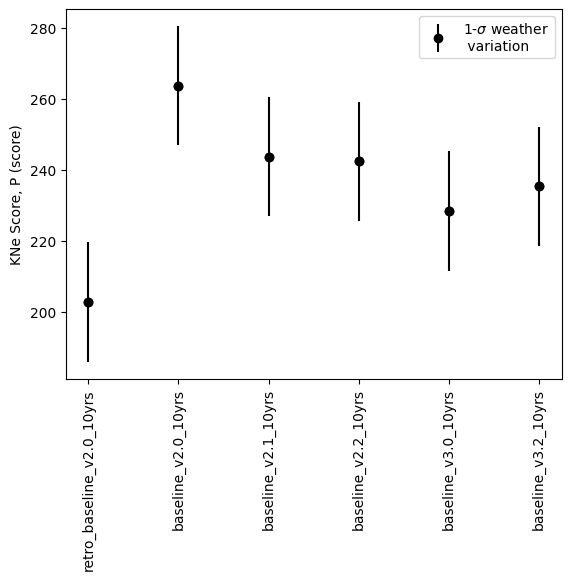

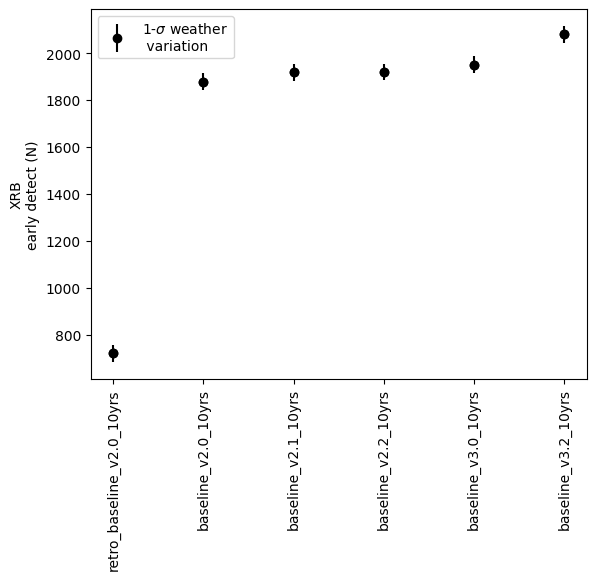

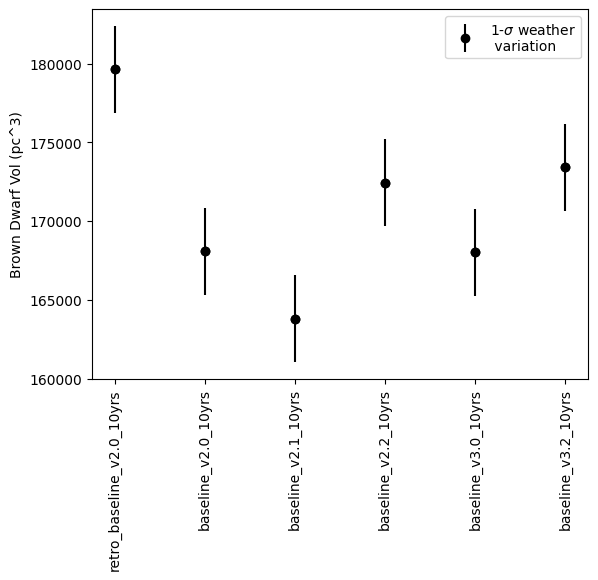

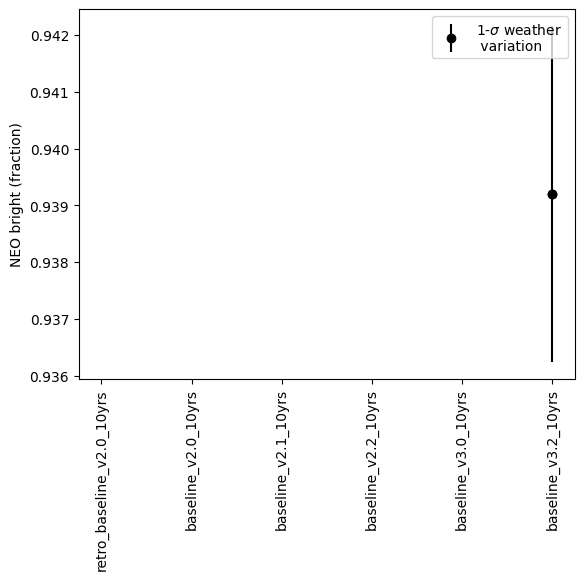

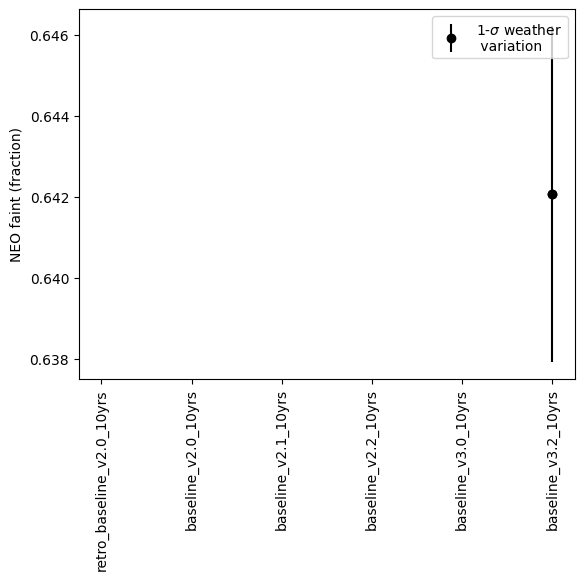

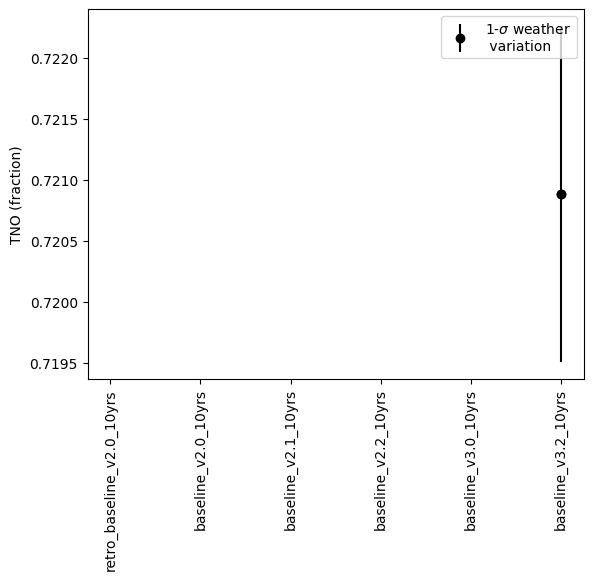

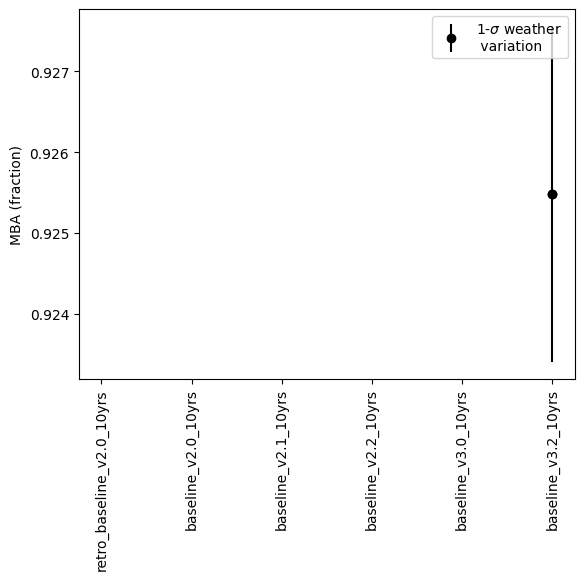

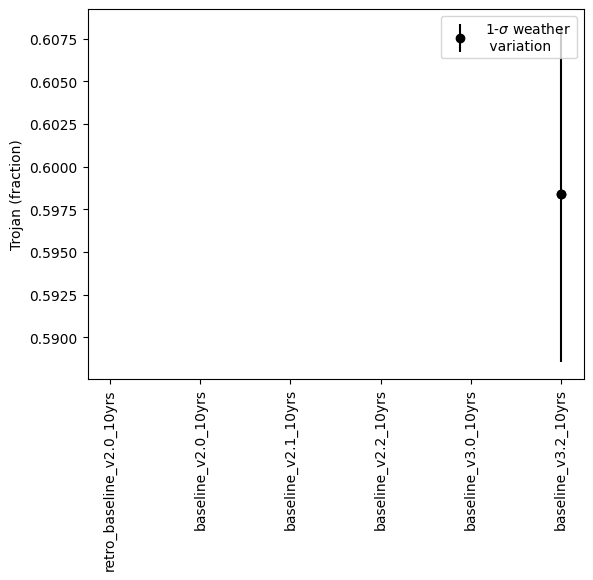

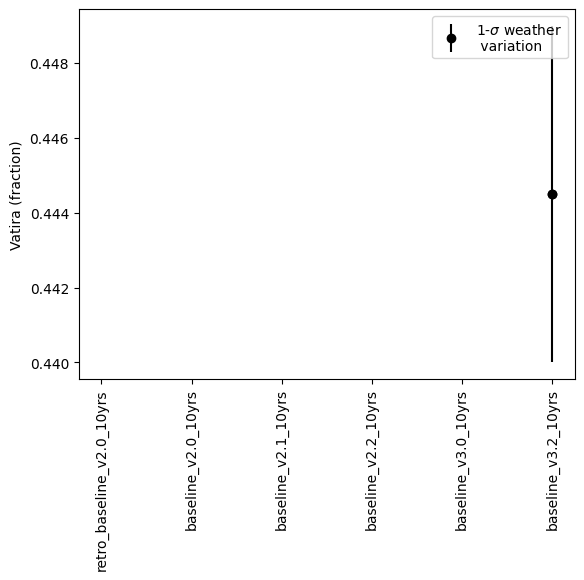

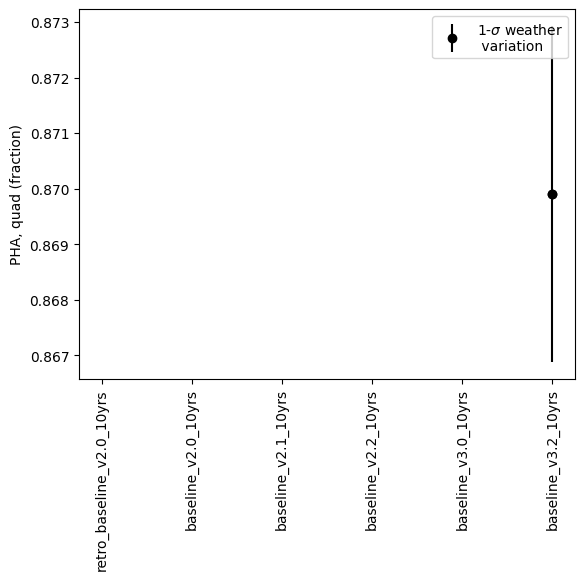

In [17]:
# Rough error bars from weather simulations
std_dict = {}
weather_runs = [run for run in data.index if 'weather' in run]
for col in data.columns:
    std_dict[col] = np.std(data.loc[weather_runs][col])

std_mag_dict = {}
for col in mag_data.columns:
    std_mag_dict[col] = np.std(mag_data.loc[weather_runs][col])
    
std_ddf_dict = {}
for col in ddf_data.columns:
    std_ddf_dict[col] = np.std(ddf_data.loc[weather_runs][col])
 

std_gaps_dict = {}
for col in gaps_data.columns:
    std_gaps_dict[col] = np.std(gaps_data.loc[weather_runs][col])


#col = data.columns[0]
for col in sub_data.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_data[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_data[col].values.size), sub_data[col], yerr=std_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    if units[col] != '':
        label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


/var/folders/jv/jdhmc2t93njct5cx375mztcr0000gn/T/ipykernel_16587/1292493311.py:5: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s" (-> marker='s'). The keyword argument will take precedence.
  h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',


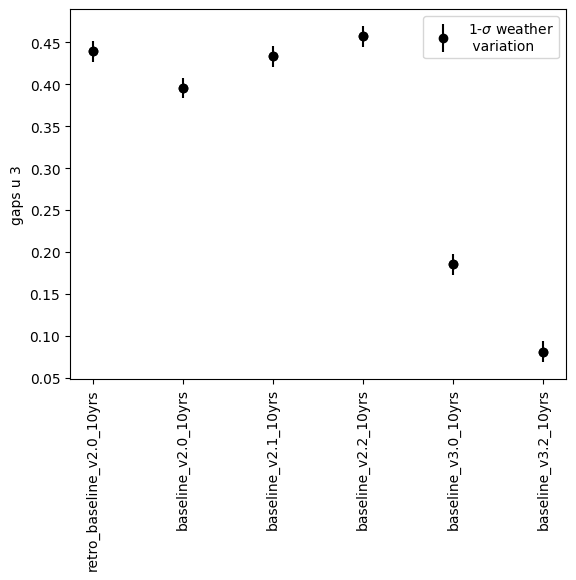

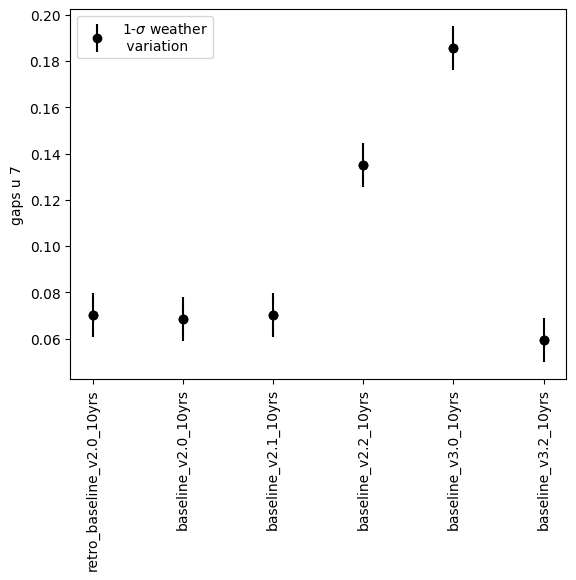

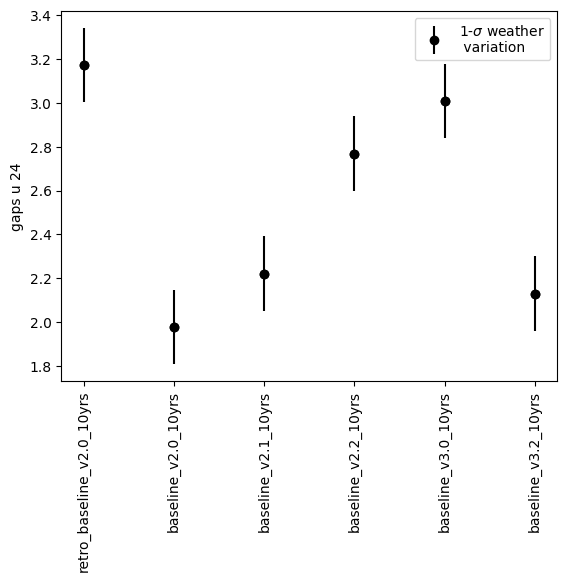

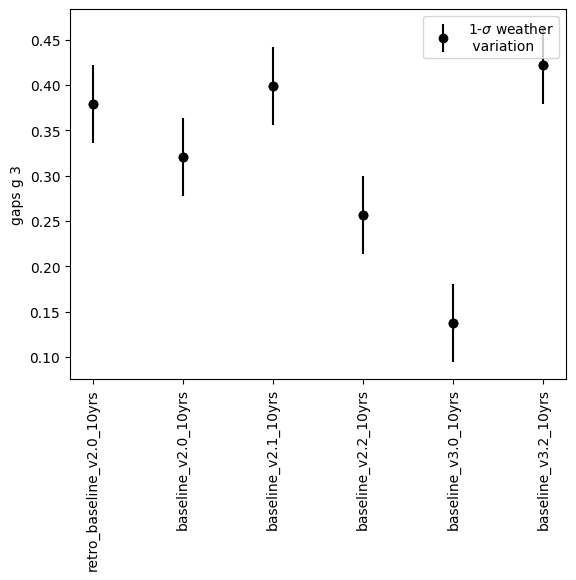

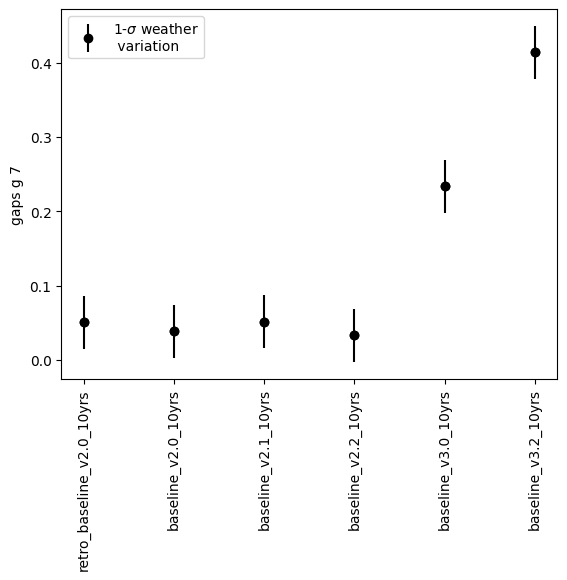

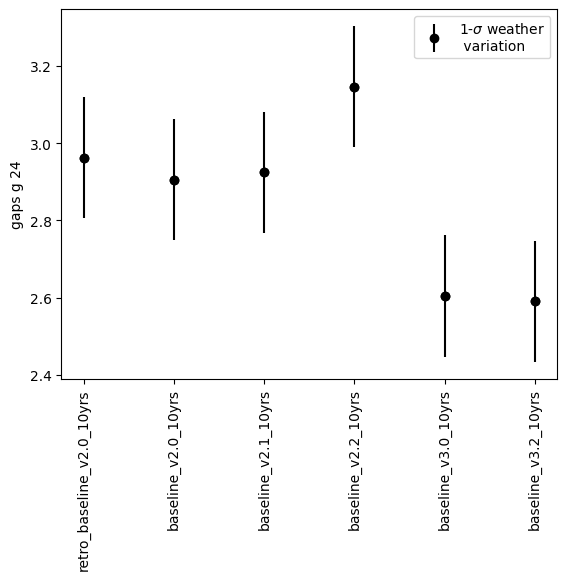

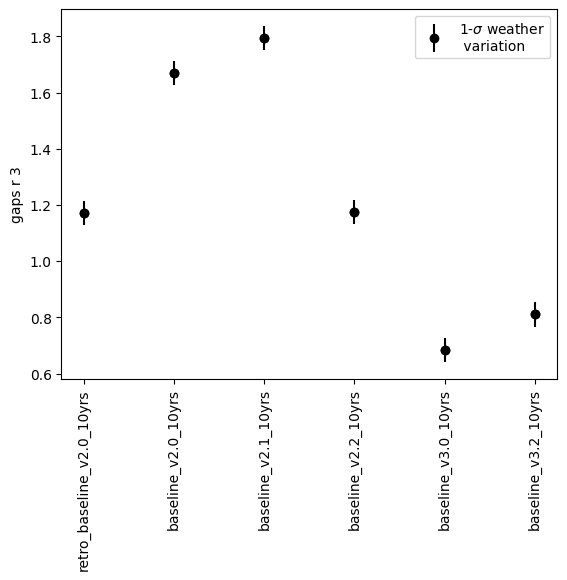

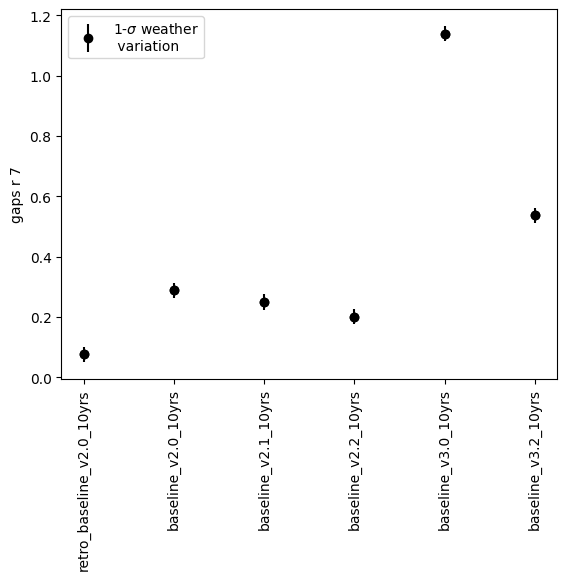

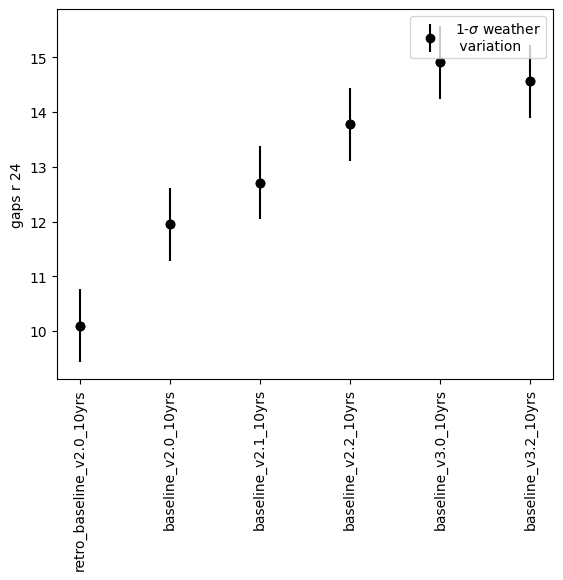

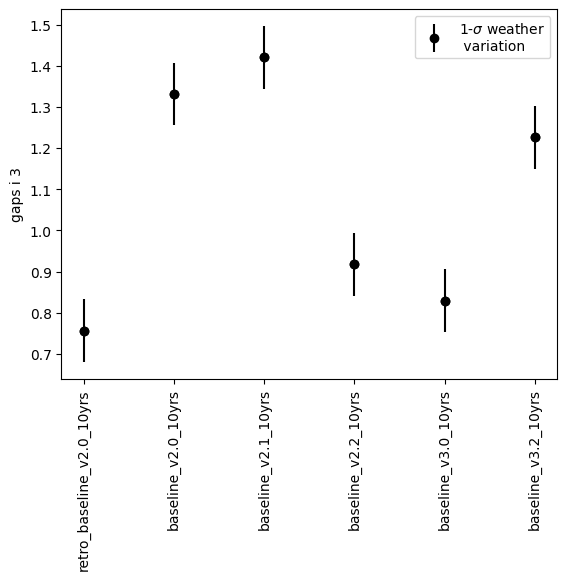

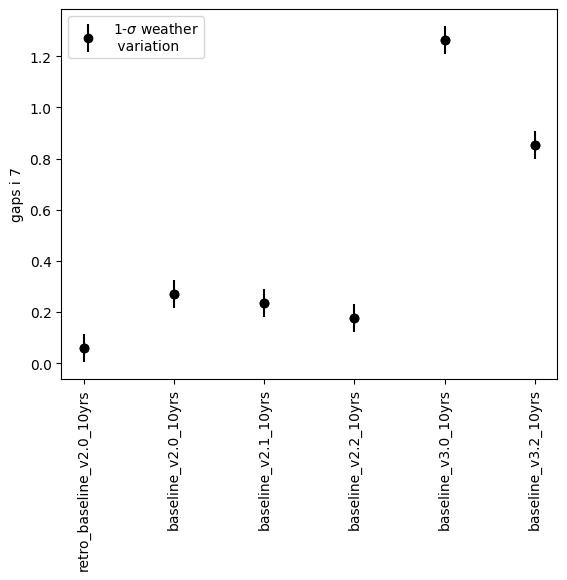

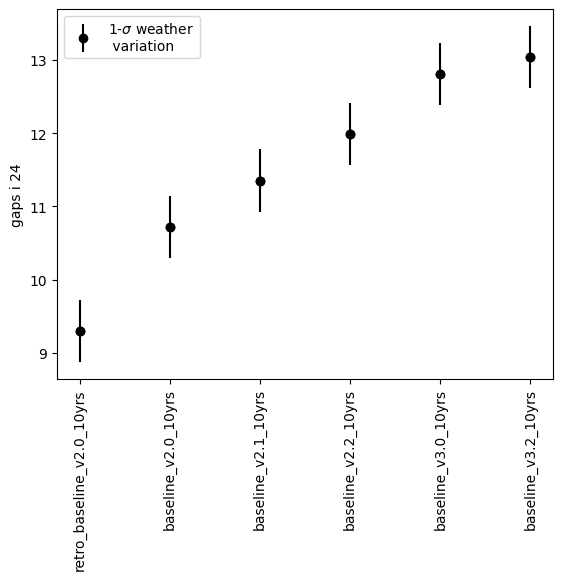

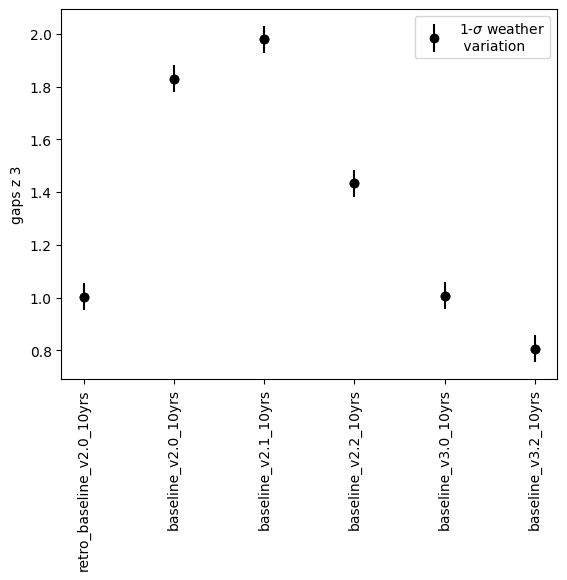

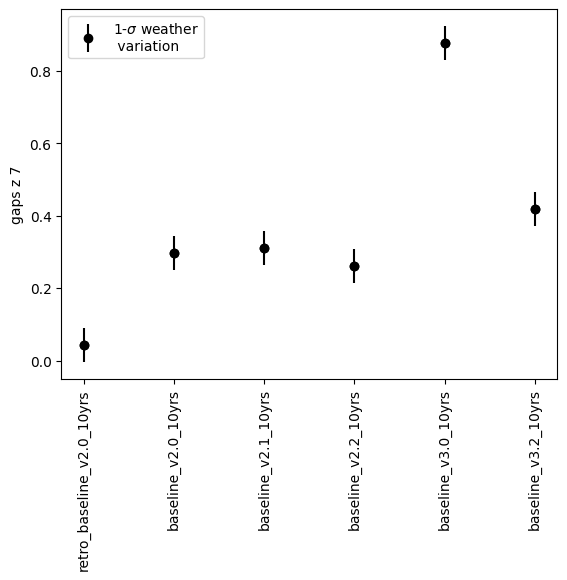

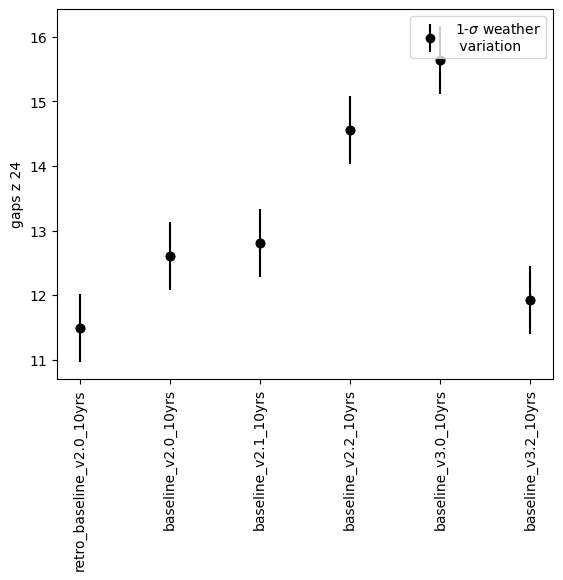

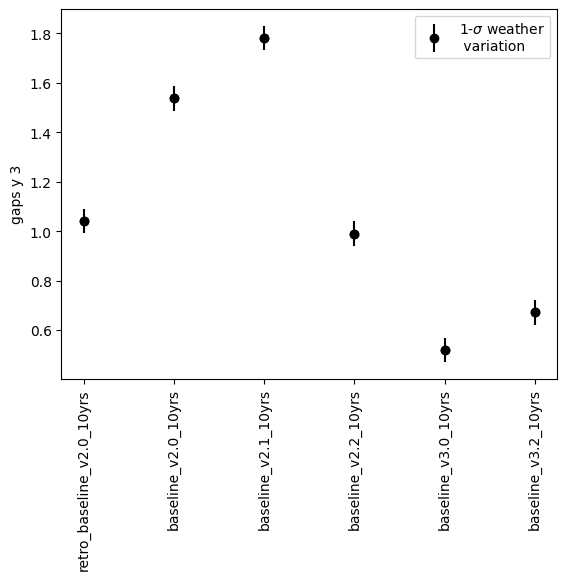

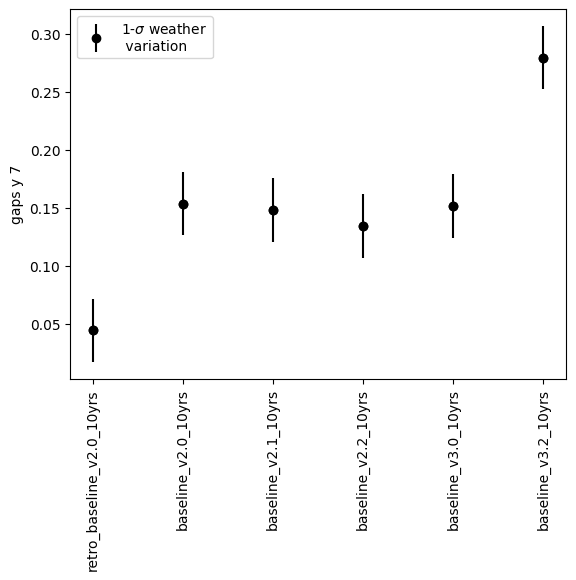

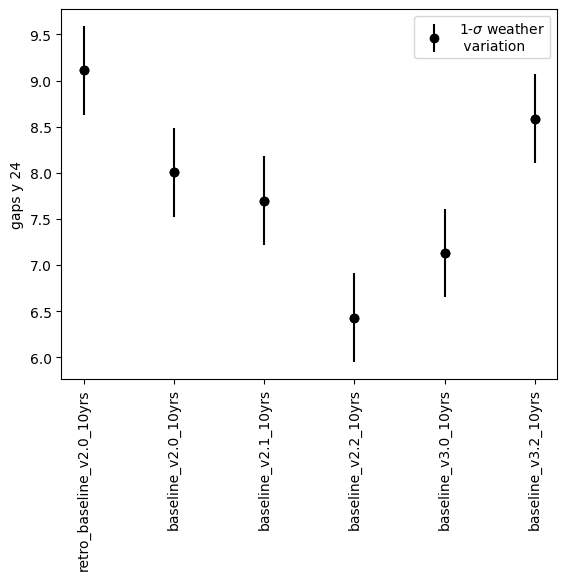

In [18]:
for col in sub_gaps.columns:
    fig, ax = plt.subplots()
    ax.plot(sub_gaps[col], 'ko')
    label_add = ''
    h0 = ax.errorbar(np.arange(sub_gaps[col].values.size), sub_gaps[col], yerr=std_gaps_dict[col], fmt='s', color='k',
               label=r'1-$\sigma$ weather'
                '\n variation', marker='o')
    #if units[col] != '':
    #    label_add = ' (' + units[col]+')'
    ax.set_ylabel(col + label_add)
    ax.tick_params(axis='x', labelrotation = 90)
    hh=[h0]
    ax.legend(hh, [H.get_label() for H in hh],
        handler_map={type(h0): HandlerErrorbar(xerr_size=1)})
    if col in invert_cols:
        ax.set_ylim(ax.get_ylim()[::-1])


In [19]:
# so, we can think about what summary stats make the most sense for gaps. Might be top 18k sq degrees